# Tag Analysis - Everbee Shop

## Objective
This notebook performs comprehensive analysis of product tags to identify:
- **Tag Performance**: Which tags drive the most sales and revenue
- **Tag Economics**: CPC, competition, and ROI analysis
- **Tag Combinations**: Best performing tag strategies
- **Tag Opportunities**: High-volume, low-competition tags
- **Strategic Recommendations**: Actionable insights for tag optimization

## Data Source
- `json_files_total_reviewrs/` - Products ranked by reviewers
- `json_files_total_sales/` - Products ranked by sales


In [207]:
# Import libraries
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Any, Optional
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Step 1: Load All JSON Files


In [208]:
# Load all JSON files
folder_reviewrs = 'json_files_total_reviewrs'
folder_sales = 'json_files_total_sales'

json_files_reviewrs = []
json_files_sales = []

if os.path.exists(folder_reviewrs):
    json_files_reviewrs = [f for f in os.listdir(folder_reviewrs) if f.endswith('.json')]
    print(f"✓ Found {len(json_files_reviewrs)} files in {folder_reviewrs}/")

if os.path.exists(folder_sales):
    json_files_sales = [f for f in os.listdir(folder_sales) if f.endswith('.json')]
    print(f"✓ Found {len(json_files_sales)} files in {folder_sales}/")

total_files = len(json_files_reviewrs) + len(json_files_sales)
print(f"\n📊 Total JSON files to process: {total_files}")

print("\n💡 Explanation: Loading all JSON files from both folders to extract tag data")


✓ Found 29 files in json_files_total_reviewrs/
✓ Found 1 files in json_files_total_sales/

📊 Total JSON files to process: 30

💡 Explanation: Loading all JSON files from both folders to extract tag data


## Step 2: Extract Product and Tag Data


In [209]:
def extract_product_and_tags(file_path: str, folder_type: str) -> Dict[str, Any]:
    """
    Extract product information and tags analysis from JSON file.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        listing = data.get('listing', {})
        listing_id = listing.get('listing_id')
        title = listing.get('title', '')
        price = float(listing.get('price', 0) or 0)
        sales = int(listing.get('transaction_sold_count', 0) or 0)
        revenue = price * sales
        views = int(listing.get('views', 0) or 0)
        conversion_rate = float(listing.get('conversion_rate', 0) or 0)
        visibility_score = float(listing.get('visibility_score', 0) or 0)
        
        # Extract tags analysis (it's at top level, not in listing)
        tags_analysis = data.get('tags_analysis', [])
        tags_list = []
        
        for tag_data in tags_analysis:
            try:
                # Field names: keyword (not tag), vol (not volume), score is string
                keyword = tag_data.get('keyword', '')
                vol = int(tag_data.get('vol', 0) or 0)
                competition = float(tag_data.get('competition', 0) or 0)
                score_str = tag_data.get('score', '0')
                score = float(score_str) if score_str else 0.0
                cpc = float(tag_data.get('cpc', 0)) if tag_data.get('cpc') is not None else None
                
                tag_info = {
                    'listing_id': listing_id,
                    'title': title,
                    'tag': keyword,  # Using 'tag' as column name for consistency
                    'volume': vol,  # Average monthly searches
                    'competition': competition,  # Total listings competing
                    'score': score,  # Ratio of volume to competition
                    'cpc': cpc,  # Cost per click (can be None)
                    'product_price': price,
                    'product_sales': sales,
                    'product_revenue': revenue,
                    'product_views': views,
                    'conversion_rate': conversion_rate,
                    'visibility_score': visibility_score,
                    'folder_source': folder_type,
                }
                tags_list.append(tag_info)
            except Exception as e:
                continue
        
        return {
            'product_info': {
                'listing_id': listing_id,
                'title': title,
                'price': price,
                'total_sales': sales,
                'total_revenue': revenue,
                'views': views,
                'conversion_rate': conversion_rate,
                'visibility_score': visibility_score,
                'folder_source': folder_type,
            },
            'tags': tags_list
        }
    except Exception as e:
        return {'product_info': None, 'tags': []}

print("✓ Extraction function created")
print("\n💡 Explanation: This function extracts product data and tag analysis from each JSON file")
print("   Key tag metrics: volume (monthly searches), competition, score, and CPC")


✓ Extraction function created

💡 Explanation: This function extracts product data and tag analysis from each JSON file
   Key tag metrics: volume (monthly searches), competition, score, and CPC


In [210]:
# Extract all data from JSON files
all_products_info = []
all_tags = []

print("Processing reviewrs folder...")
for filename in json_files_reviewrs:
    file_path = os.path.join(folder_reviewrs, filename)
    data = extract_product_and_tags(file_path, 'reviewrs')
    if data['product_info']:
        all_products_info.append(data['product_info'])
    all_tags.extend(data['tags'])

print(f"✓ Processed {len(json_files_reviewrs)} files from reviewrs")

print("\nProcessing sales folder...")
for filename in json_files_sales:
    file_path = os.path.join(folder_sales, filename)
    data = extract_product_and_tags(file_path, 'sales')
    if data['product_info']:
        all_products_info.append(data['product_info'])
    all_tags.extend(data['tags'])

print(f"✓ Processed {len(json_files_sales)} files from sales")

# Create DataFrames
products_df = pd.DataFrame(all_products_info)

if all_tags:
    tags_df = pd.DataFrame(all_tags)
    print(f"\n✓ Extracted {len(tags_df)} tag records")
    print(f"  - Unique products: {tags_df['listing_id'].nunique()}")
    print(f"  - Unique tags: {tags_df['tag'].nunique()}")
    print(f"  - Tags with CPC data: {tags_df['cpc'].notna().sum()}")
else:
    tags_df = pd.DataFrame()
    print("\n⚠ No tag data found")

print(f"\n✓ Total products: {len(products_df)}")
print("\n💡 Explanation: Extracted all product and tag data into DataFrames for analysis")


Processing reviewrs folder...
✓ Processed 29 files from reviewrs

Processing sales folder...
✓ Processed 1 files from sales

✓ Extracted 390 tag records
  - Unique products: 29
  - Unique tags: 140
  - Tags with CPC data: 137

✓ Total products: 30

💡 Explanation: Extracted all product and tag data into DataFrames for analysis


## Step 3: Data Cleaning & Preparation


In [211]:
# Clean and prepare tag data
if len(tags_df) > 0:
    # Remove tags with null CPC or zero CPC (as per requirement)
    initial_count = len(tags_df)
    null_cpc_count = tags_df['cpc'].isna().sum()
    zero_cpc_count = (tags_df['cpc'] == 0).sum()
    
    # Filter: keep only tags with CPC that is not null AND greater than zero
    tags_df = tags_df[(tags_df['cpc'].notna()) & (tags_df['cpc'] > 0)].copy()
    removed_count = initial_count - len(tags_df)
    
    print(f"📊 Data Cleaning Summary:")
    print(f"  • Initial tag records: {initial_count}")
    print(f"  • Removed tags with null CPC: {null_cpc_count}")
    print(f"  • Removed tags with zero CPC: {zero_cpc_count}")
    print(f"  • Total removed: {removed_count}")
    print(f"  • Remaining tag records: {len(tags_df)}")
    
    # Calculate additional metrics
    tags_df['cpc_price_ratio'] = (tags_df['cpc'] / tags_df['product_price']) * 100
    tags_df['volume_competition_ratio'] = tags_df['volume'] / (tags_df['competition'] + 1)  # +1 to avoid division by zero
    
    # Calculate estimated ROI (simplified: assuming conversion rate applies)
    tags_df['estimated_roi'] = ((tags_df['product_price'] - tags_df['cpc']) / tags_df['cpc']) * 100
    tags_df['estimated_roi'] = tags_df['estimated_roi'].fillna(0)
    
    print(f"\n✓ Calculated additional metrics:")
    print(f"  • CPC/Price ratio: {tags_df['cpc_price_ratio'].mean():.2f}% average")
    print(f"  • Volume/Competition ratio: {tags_df['volume_competition_ratio'].mean():.2f} average")
    print(f"  • Estimated ROI: {tags_df['estimated_roi'].mean():.2f}% average")
    
    print(f"\n💡 Explanation: Cleaned data by removing null and zero CPC values")
    print(f"   Added metrics: CPC/Price ratio, Volume/Competition ratio, and estimated ROI")
else:
    print("⚠ No tag data available for cleaning")


📊 Data Cleaning Summary:
  • Initial tag records: 390
  • Removed tags with null CPC: 253
  • Removed tags with zero CPC: 38
  • Total removed: 291
  • Remaining tag records: 99

✓ Calculated additional metrics:
  • CPC/Price ratio: 35.65% average
  • Volume/Competition ratio: 0.05 average
  • Estimated ROI: 677.81% average

💡 Explanation: Cleaned data by removing null and zero CPC values
   Added metrics: CPC/Price ratio, Volume/Competition ratio, and estimated ROI


## Step 4: Tag Performance Analysis


In [212]:
# Analyze tag performance by aggregating metrics per tag
if len(tags_df) > 0:
    print("="*80)
    print("TAG PERFORMANCE ANALYSIS")
    print("="*80)
    
    # Aggregate tag performance
    tag_performance = tags_df.groupby('tag').agg({
        'listing_id': 'nunique',  # Number of products using this tag
        'product_revenue': 'sum',  # Total revenue from products with this tag
        'product_sales': 'sum',  # Total sales from products with this tag
        'volume': 'mean',  # Average search volume
        'competition': 'mean',  # Average competition
        'score': 'mean',  # Average score
        'cpc': 'mean',  # Average CPC
        'cpc_price_ratio': 'mean',  # Average CPC/Price ratio
        'volume_competition_ratio': 'mean',  # Average volume/competition ratio
        'estimated_roi': 'mean',  # Average estimated ROI
    }).reset_index()
    
    tag_performance.columns = [
        'tag', 'products_count', 'total_revenue', 'total_sales',
        'avg_volume', 'avg_competition', 'avg_score', 'avg_cpc',
        'avg_cpc_price_ratio', 'avg_volume_competition_ratio', 'avg_estimated_roi'
    ]
    
    # Sort by different metrics
    tag_performance_by_revenue = tag_performance.nlargest(10, 'total_revenue')
    tag_performance_by_sales = tag_performance.nlargest(10, 'total_sales')
    tag_performance_by_score = tag_performance.nlargest(10, 'avg_score')
    
    print(f"\n📊 Tag Performance Summary:")
    print(f"  • Total unique tags analyzed: {len(tag_performance)}")
    print(f"  • Total revenue across all tags: ${tag_performance['total_revenue'].sum():,.2f}")
    print(f"  • Total sales across all tags: {tag_performance['total_sales'].sum():,}")
    
    print(f"\n🔝 Top 10 Tags by Revenue:")
    for idx, row in tag_performance_by_revenue.iterrows():
        print(f"  {idx+1}. {row['tag']}")
        print(f"     Revenue: ${row['total_revenue']:,.2f} | Sales: {int(row['total_sales']):,} | Products: {int(row['products_count'])}")
    
    print(f"\n🔝 Top 10 Tags by Sales Volume:")
    for idx, row in tag_performance_by_sales.iterrows():
        print(f"  {idx+1}. {row['tag']}")
        print(f"     Sales: {int(row['total_sales']):,} | Revenue: ${row['total_revenue']:,.2f} | Products: {int(row['products_count'])}")
    
    print(f"\n🔝 Top 10 Tags by Score (Volume/Competition Ratio):")
    for idx, row in tag_performance_by_score.iterrows():
        print(f"  {idx+1}. {row['tag']}")
        print(f"     Score: {row['avg_score']:.2f} | Volume: {row['avg_volume']:,.0f} | Competition: {row['avg_competition']:,.0f}")
    
    print(f"\n💡 Explanation: Aggregated tag metrics to identify best performing tags")
    print(f"   High revenue tags = proven money makers")
    print(f"   High score tags = high demand, low competition (easier to rank)")
    
else:
    tag_performance = pd.DataFrame()
    print("⚠ No tag data available for performance analysis")


TAG PERFORMANCE ANALYSIS

📊 Tag Performance Summary:
  • Total unique tags analyzed: 37
  • Total revenue across all tags: $50,341,759.63
  • Total sales across all tags: 32,177,413

🔝 Top 10 Tags by Revenue:
  2. bullet journal idea
     Revenue: $13,369,498.68 | Sales: 8,776,358 | Products: 26
  26. printable agenda
     Revenue: $8,001,462.18 | Sales: 5,197,667 | Products: 15
  23. monthly tracker
     Revenue: $2,928,024.00 | Sales: 1,952,016 | Products: 6
  18. health tracker
     Revenue: $2,928,016.50 | Sales: 1,952,011 | Products: 6
  1. book journal
     Revenue: $1,952,016.00 | Sales: 1,301,344 | Products: 4
  28. printable book
     Revenue: $1,948,890.00 | Sales: 1,299,260 | Products: 4
  16. health journal
     Revenue: $1,464,012.00 | Sales: 976,008 | Products: 3
  30. sleep analysis
     Revenue: $1,464,012.00 | Sales: 976,008 | Products: 3
  17. health planner
     Revenue: $976,008.00 | Sales: 650,672 | Products: 2
  15. guess who baby game
     Revenue: $927,207.60 | 

## Step 5: Tag Economics Analysis (CPC & ROI)


In [213]:
# Analyze tag economics: CPC efficiency and ROI
if len(tags_df) > 0:
    print("="*80)
    print("TAG ECONOMICS ANALYSIS")
    print("="*80)
    
    # Calculate CPC efficiency metrics
    tags_df['cpc_efficiency'] = tags_df['product_price'] / tags_df['cpc']  # How many times price vs CPC
    
    # Classify tags by economics
    tags_df['cpc_category'] = pd.cut(
        tags_df['cpc_price_ratio'],
        bins=[0, 5, 10, 20, 100],
        labels=['Very Low (<5%)', 'Low (5-10%)', 'Medium (10-20%)', 'High (>20%)']
    )
    
    # Economic analysis per tag
    tag_economics = tags_df.groupby('tag').agg({
        'cpc': 'mean',
        'cpc_price_ratio': 'mean',
        'estimated_roi': 'mean',
        'cpc_efficiency': 'mean',
        'product_price': 'mean',
        'product_revenue': 'sum',
    }).reset_index()
    
    tag_economics.columns = [
        'tag', 'avg_cpc', 'avg_cpc_price_ratio', 'avg_estimated_roi',
        'avg_cpc_efficiency', 'avg_product_price', 'total_revenue'
    ]
    
    print(f"\n📊 CPC Economics Summary:")
    print(f"  • Average CPC: ${tag_economics['avg_cpc'].mean():.2f}")
    print(f"  • Average CPC/Price ratio: {tag_economics['avg_cpc_price_ratio'].mean():.2f}%")
    print(f"  • Average estimated ROI: {tag_economics['avg_estimated_roi'].mean():.2f}%")
    print(f"  • Average CPC efficiency: {tag_economics['avg_cpc_efficiency'].mean():.2f}x")
    
    print(f"\n💰 CPC Category Distribution:")
    cpc_distribution = tags_df['cpc_category'].value_counts()
    for category, count in cpc_distribution.items():
        pct = (count / len(tags_df)) * 100
        print(f"  • {category}: {count} tags ({pct:.1f}%)")
    
    # Best economical tags (low CPC relative to price, high ROI)
    economical_tags = tag_economics[
        (tag_economics['avg_cpc_price_ratio'] < 10) & 
        (tag_economics['avg_estimated_roi'] > 0)
    ].nlargest(10, 'avg_estimated_roi')
    
    print(f"\n💎 Top 10 Most Economical Tags (Low CPC/Price, High ROI):")
    for idx, row in economical_tags.iterrows():
        print(f"  {idx+1}. {row['tag']}")
        print(f"     CPC/Price: {row['avg_cpc_price_ratio']:.2f}% | ROI: {row['avg_estimated_roi']:.1f}% | Revenue: ${row['total_revenue']:,.2f}")
    
    # Expensive tags (high CPC relative to price)
    expensive_tags = tag_economics.nlargest(10, 'avg_cpc_price_ratio')
    print(f"\n⚠️  Top 10 Most Expensive Tags (High CPC/Price Ratio):")
    for idx, row in expensive_tags.iterrows():
        print(f"  {idx+1}. {row['tag']}")
        print(f"     CPC/Price: {row['avg_cpc_price_ratio']:.2f}% | CPC: ${row['avg_cpc']:.2f} | Avg Price: ${row['avg_product_price']:.2f}")
    
    print(f"\n💡 Explanation: Analyzed tag economics to identify cost-effective tags")
    print(f"   Low CPC/Price ratio = more cost-effective advertising")
    print(f"   High ROI = better return on ad spend")
    
else:
    tag_economics = pd.DataFrame()
    print("⚠ No tag data available for economics analysis")


TAG ECONOMICS ANALYSIS

📊 CPC Economics Summary:
  • Average CPC: $0.68
  • Average CPC/Price ratio: 46.28%
  • Average estimated ROI: 1005.27%
  • Average CPC efficiency: 11.05x

💰 CPC Category Distribution:
  • Medium (10-20%): 55 tags (55.6%)
  • High (>20%): 20 tags (20.2%)
  • Low (5-10%): 5 tags (5.1%)
  • Very Low (<5%): 5 tags (5.1%)

💎 Top 10 Most Economical Tags (Low CPC/Price, High ROI):
  35. weigh in
     CPC/Price: 1.33% | ROI: 7400.0% | Revenue: $487,996.50
  3. cash stuffing
     CPC/Price: 1.36% | ROI: 7266.7% | Revenue: $718,981.51
  31. step counter
     CPC/Price: 2.00% | ROI: 4900.0% | Revenue: $488,004.00
  20. marker set
     CPC/Price: 3.29% | ROI: 2942.9% | Revenue: $692,965.68
  21. menstruation tracker
     CPC/Price: 4.00% | ROI: 2400.0% | Revenue: $479,581.50
  22. mom or dad
     CPC/Price: 5.96% | ROI: 1576.5% | Revenue: $927,207.60
  6. colour test
     CPC/Price: 7.04% | ROI: 1320.0% | Revenue: $692,965.68
  4. color test
     CPC/Price: 7.04% | ROI: 13

## Step 6: Tag Opportunities Analysis (High Volume, Low Competition)


In [214]:
# Identify tag opportunities: high volume, low competition
if len(tags_df) > 0:
    print("="*80)
    print("TAG OPPORTUNITIES ANALYSIS")
    print("="*80)
    
    # Calculate opportunity score (high volume, low competition = high opportunity)
    tags_df['opportunity_score'] = (tags_df['volume'] / (tags_df['competition'] + 1)) * tags_df['score']
    
    # Classify opportunities
    volume_median = tags_df['volume'].median()
    competition_median = tags_df['competition'].median()
    score_median = tags_df['score'].median()
    
    # High opportunity tags: high volume, low competition, good score
    high_opportunity = tags_df[
        (tags_df['volume'] > volume_median) &
        (tags_df['competition'] < competition_median) &
        (tags_df['score'] > score_median)
    ].copy()
    
    # Aggregate opportunities by tag
    tag_opportunities = high_opportunity.groupby('tag').agg({
        'volume': 'mean',
        'competition': 'mean',
        'score': 'mean',
        'opportunity_score': 'mean',
        'cpc': 'mean',
        'product_revenue': 'sum',
        'listing_id': 'nunique',
    }).reset_index()
    
    tag_opportunities.columns = [
        'tag', 'avg_volume', 'avg_competition', 'avg_score',
        'avg_opportunity_score', 'avg_cpc', 'total_revenue', 'products_count'
    ]
    
    tag_opportunities = tag_opportunities.sort_values('avg_opportunity_score', ascending=False)
    
    print(f"\n📊 Opportunity Thresholds:")
    print(f"  • Volume median: {volume_median:,.0f} monthly searches")
    print(f"  • Competition median: {competition_median:,.0f} listings")
    print(f"  • Score median: {score_median:.2f}")
    
    print(f"\n🎯 High Opportunity Tags Found: {len(tag_opportunities)}")
    print(f"   (High volume + Low competition + Good score)")
    
    print(f"\n🔝 Top 20 High Opportunity Tags:")
    for idx, row in tag_opportunities.head(20).iterrows():
        print(f"  {idx+1}. {row['tag']}")
        print(f"     Volume: {row['avg_volume']:,.0f} | Competition: {row['avg_competition']:,.0f} | Score: {row['avg_score']:.2f}")
        print(f"     Opportunity Score: {row['avg_opportunity_score']:.2f} | Revenue: ${row['total_revenue']:,.2f}")
    
    # Low competition, high volume gems
    gems = tags_df[
        (tags_df['volume'] > volume_median * 1.5) &
        (tags_df['competition'] < competition_median * 0.5)
    ].groupby('tag').agg({
        'volume': 'mean',
        'competition': 'mean',
        'score': 'mean',
        'product_revenue': 'sum',
    }).reset_index()
    
    gems.columns = ['tag', 'avg_volume', 'avg_competition', 'avg_score', 'total_revenue']
    gems = gems.sort_values('avg_score', ascending=False)
    
    print(f"\n💎 Hidden Gems (Very High Volume, Very Low Competition):")
    for idx, row in gems.head(10).iterrows():
        print(f"  {idx+1}. {row['tag']}")
        print(f"     Volume: {row['avg_volume']:,.0f} | Competition: {row['avg_competition']:,.0f} | Score: {row['avg_score']:.2f}")
    
    print(f"\n💡 Explanation: Identified tags with high search volume but low competition")
    print(f"   These are opportunities for easier ranking and better visibility")
    print(f"   High opportunity score = best potential for growth")
    
else:
    tag_opportunities = pd.DataFrame()
    print("⚠ No tag data available for opportunities analysis")


TAG OPPORTUNITIES ANALYSIS

📊 Opportunity Thresholds:
  • Volume median: 865 monthly searches
  • Competition median: 25,622 listings
  • Score median: 40.00

🎯 High Opportunity Tags Found: 0
   (High volume + Low competition + Good score)

🔝 Top 20 High Opportunity Tags:

💎 Hidden Gems (Very High Volume, Very Low Competition):

💡 Explanation: Identified tags with high search volume but low competition
   These are opportunities for easier ranking and better visibility
   High opportunity score = best potential for growth


## Step 7: Tag Combinations Analysis


In [215]:
# Analyze tag combinations - which tags work well together
if len(tags_df) > 0:
    print("="*80)
    print("TAG COMBINATIONS ANALYSIS")
    print("="*80)
    
    # Get tags per product
    product_tags = tags_df.groupby('listing_id')['tag'].apply(list).reset_index()
    product_tags.columns = ['listing_id', 'tags']
    
    # Get product metrics
    product_metrics = tags_df.groupby('listing_id').agg({
        'product_revenue': 'first',
        'product_sales': 'first',
        'product_price': 'first',
    }).reset_index()
    
    # Merge
    product_tags = product_tags.merge(product_metrics, on='listing_id')
    
    # Find common tag pairs
    tag_pairs = []
    for _, row in product_tags.iterrows():
        tags = row['tags']
        revenue = row['product_revenue']
        sales = row['product_sales']
        
        # Generate all pairs from tags
        for i in range(len(tags)):
            for j in range(i+1, len(tags)):
                pair = tuple(sorted([tags[i], tags[j]]))
                tag_pairs.append({
                    'tag1': pair[0],
                    'tag2': pair[1],
                    'product_revenue': revenue,
                    'product_sales': sales,
                })
    
    if tag_pairs:
        pairs_df = pd.DataFrame(tag_pairs)
        
        # Aggregate pair performance
        pair_performance = pairs_df.groupby(['tag1', 'tag2']).agg({
            'product_revenue': ['sum', 'mean', 'count'],
            'product_sales': 'sum',
        }).reset_index()
        
        pair_performance.columns = ['tag1', 'tag2', 'total_revenue', 'avg_revenue', 'products_count', 'total_sales']
        
        # Sort by performance
        best_pairs = pair_performance.nlargest(15, 'total_revenue')
        
        print(f"\n📊 Tag Pair Analysis:")
        print(f"  • Total unique tag pairs found: {len(pair_performance)}")
        print(f"  • Average revenue per pair: ${pair_performance['total_revenue'].mean():,.2f}")
        
        print(f"\n🔝 Top 15 Best Performing Tag Combinations:")
        for idx, row in best_pairs.iterrows():
            print(f"  {idx+1}. '{row['tag1']}' + '{row['tag2']}'")
            print(f"     Total Revenue: ${row['total_revenue']:,.2f} | Products: {int(row['products_count'])} | Avg Revenue: ${row['avg_revenue']:,.2f}")
        
        # Find high-performing pairs with good economics
        if len(tag_economics) > 0:
            # Get tags with good economics
            economical_tag_list = set(tag_economics[tag_economics['avg_cpc_price_ratio'] < 10]['tag'].tolist())
            
            economical_pairs = pair_performance[
                (pair_performance['tag1'].isin(economical_tag_list)) &
                (pair_performance['tag2'].isin(economical_tag_list))
            ].nlargest(10, 'total_revenue')
            
            if len(economical_pairs) > 0:
                print(f"\n💎 Top 10 Economical Tag Combinations (Low CPC/Price):")
                for idx, row in economical_pairs.iterrows():
                    print(f"  {idx+1}. '{row['tag1']}' + '{row['tag2']}'")
                    print(f"     Revenue: ${row['total_revenue']:,.2f} | Products: {int(row['products_count'])}")
        
        print(f"\n💡 Explanation: Analyzed which tags perform well together")
        print(f"   Tag combinations can improve visibility and targeting")
        print(f"   Use these combinations for new products or optimization")
    else:
        print("⚠ No tag pairs found for analysis")
    
else:
    print("⚠ No tag data available for combinations analysis")


TAG COMBINATIONS ANALYSIS

📊 Tag Pair Analysis:
  • Total unique tag pairs found: 88
  • Average revenue per pair: $841,461.35

🔝 Top 15 Best Performing Tag Combinations:
  23. 'bullet journal idea' + 'printable agenda'
     Total Revenue: $8,977,455.18 | Products: 18 | Avg Revenue: $498,747.51
  20. 'bullet journal idea' + 'monthly tracker'
     Total Revenue: $2,928,024.00 | Products: 6 | Avg Revenue: $488,004.00
  16. 'bullet journal idea' + 'health tracker'
     Total Revenue: $2,928,016.50 | Products: 6 | Avg Revenue: $488,002.75
  76. 'monthly tracker' + 'printable agenda'
     Total Revenue: $2,440,020.00 | Products: 5 | Avg Revenue: $488,004.00
  1. 'book journal' + 'bullet journal idea'
     Total Revenue: $1,952,016.00 | Products: 4 | Avg Revenue: $488,004.00
  24. 'bullet journal idea' + 'printable book'
     Total Revenue: $1,948,890.00 | Products: 4 | Avg Revenue: $487,222.50
  82. 'printable agenda' + 'printable book'
     Total Revenue: $1,948,890.00 | Products: 4 | Avg 

## Step 8: Visualizations


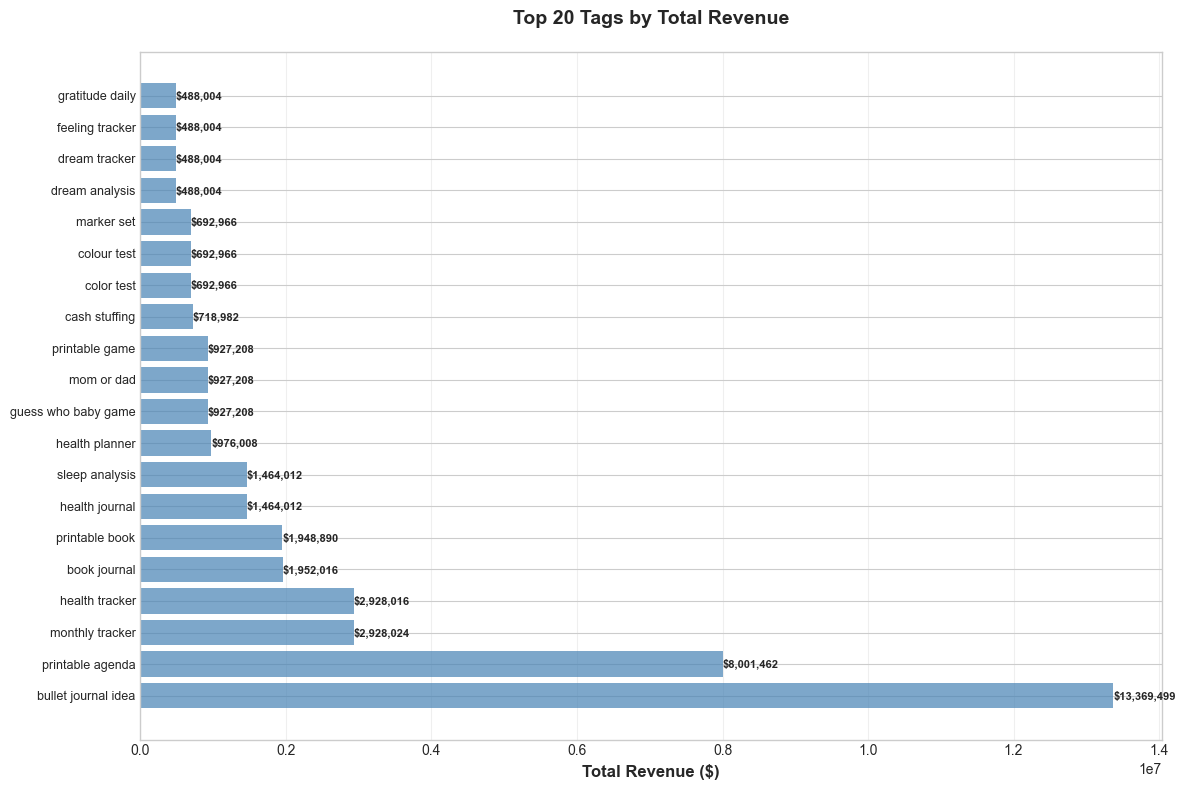

📊 Chart shows: Top 20 tags generating the most revenue
   Insight: Focus on these tags for maximum revenue impact


In [216]:
# Visualization 1: Top Tags by Revenue
if len(tag_performance) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20_revenue = tag_performance.nlargest(20, 'total_revenue')
    
    bars = ax.barh(range(len(top_20_revenue)), top_20_revenue['total_revenue'], color='steelblue', alpha=0.7)
    ax.set_yticks(range(len(top_20_revenue)))
    ax.set_yticklabels(top_20_revenue['tag'], fontsize=9)
    ax.set_xlabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Tags by Total Revenue', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(top_20_revenue.iterrows()):
        ax.text(row['total_revenue'], i, f"${row['total_revenue']:,.0f}", 
                va='center', ha='left', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Top 20 tags generating the most revenue")
    print("   Insight: Focus on these tags for maximum revenue impact")
else:
    print("⚠ No data available for visualization")


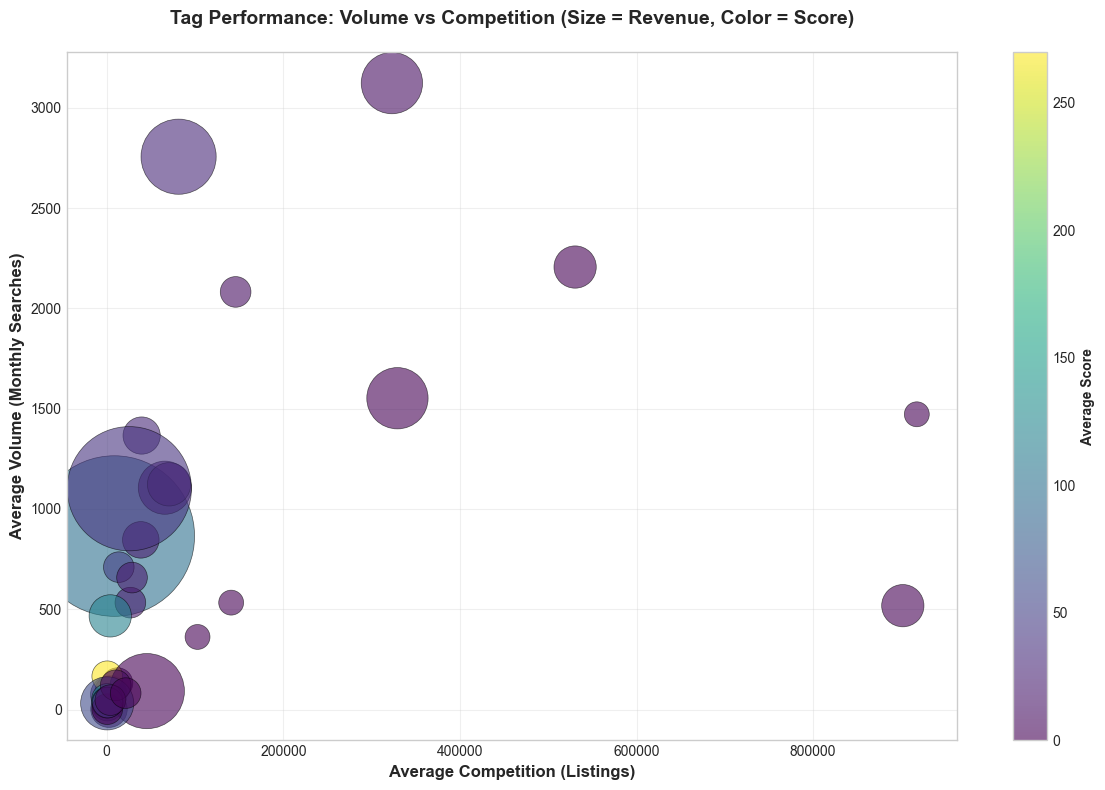

📊 Chart shows: Relationship between search volume and competition
   Insight: Top-right = high volume & high competition (competitive)
   Bottom-left = low volume & low competition (niche)
   Top-left = high volume & low competition (BEST OPPORTUNITIES)


In [217]:
# Visualization 2: Volume vs Competition Scatter Plot
if len(tag_performance) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color by score
    scatter = ax.scatter(
        tag_performance['avg_competition'],
        tag_performance['avg_volume'],
        c=tag_performance['avg_score'],
        s=tag_performance['total_revenue'] / 1000,  # Size by revenue
        alpha=0.6,
        cmap='viridis',
        edgecolors='black',
        linewidth=0.5
    )
    
    ax.set_xlabel('Average Competition (Listings)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Volume (Monthly Searches)', fontsize=12, fontweight='bold')
    ax.set_title('Tag Performance: Volume vs Competition (Size = Revenue, Color = Score)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Average Score', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Relationship between search volume and competition")
    print("   Insight: Top-right = high volume & high competition (competitive)")
    print("   Bottom-left = low volume & low competition (niche)")
    print("   Top-left = high volume & low competition (BEST OPPORTUNITIES)")
else:
    print("⚠ No data available for visualization")


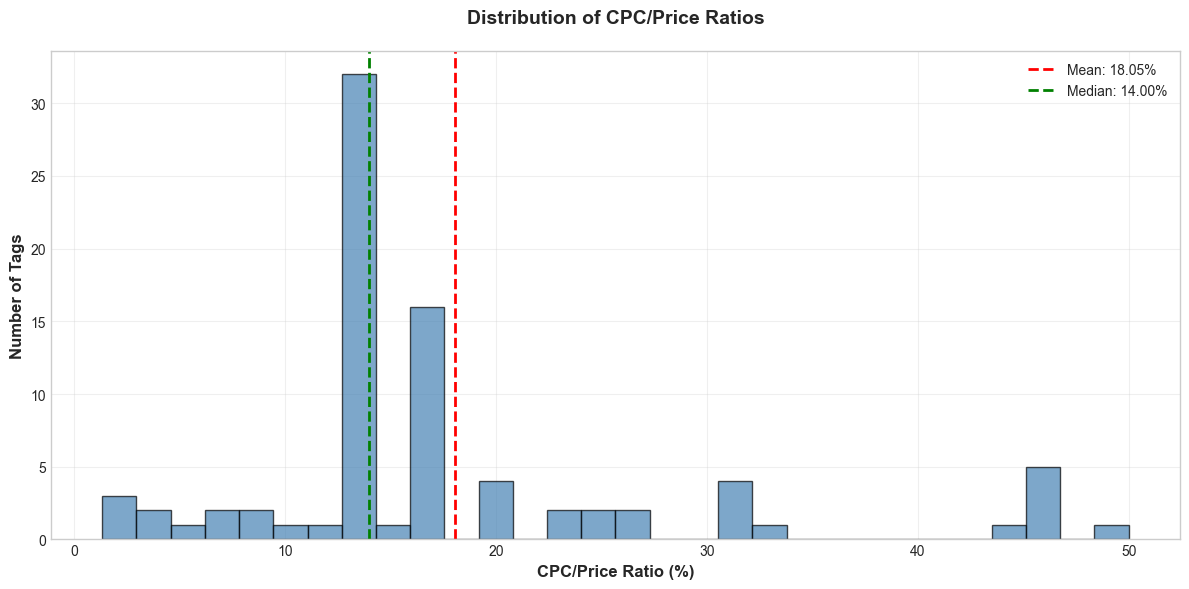

📊 Chart shows: Distribution of CPC relative to product price
   Insight: Lower ratios = more cost-effective advertising
   Most tags have CPC/Price ratio: 14.00%


In [218]:
# Visualization 3: CPC/Price Ratio Distribution
if len(tags_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Filter reasonable values for visualization
    cpc_ratio_filtered = tags_df[tags_df['cpc_price_ratio'] <= 50]['cpc_price_ratio']
    
    ax.hist(cpc_ratio_filtered, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(cpc_ratio_filtered.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cpc_ratio_filtered.mean():.2f}%')
    ax.axvline(cpc_ratio_filtered.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {cpc_ratio_filtered.median():.2f}%')
    
    ax.set_xlabel('CPC/Price Ratio (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Tags', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of CPC/Price Ratios', fontsize=14, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Distribution of CPC relative to product price")
    print("   Insight: Lower ratios = more cost-effective advertising")
    print(f"   Most tags have CPC/Price ratio: {cpc_ratio_filtered.median():.2f}%")
else:
    print("⚠ No data available for visualization")


## Step 9: Export Analysis Results


In [219]:
# Export all analysis results to CSV files
if len(tag_performance) > 0:
    # Export tag performance
    tag_performance.to_csv('tag_performance_analysis.csv', index=False, encoding='utf-8')
    print("✓ Exported: tag_performance_analysis.csv")
    
    # Export tag economics
    if len(tag_economics) > 0:
        tag_economics.to_csv('tag_economics_analysis.csv', index=False, encoding='utf-8')
        print("✓ Exported: tag_economics_analysis.csv")
    
    # Export tag opportunities
    if len(tag_opportunities) > 0:
        tag_opportunities.to_csv('tag_opportunities_analysis.csv', index=False, encoding='utf-8')
        print("✓ Exported: tag_opportunities_analysis.csv")
    
    # Export detailed tag data
    if len(tags_df) > 0:
        tags_df.to_csv('tags_detailed_data.csv', index=False, encoding='utf-8')
        print("✓ Exported: tags_detailed_data.csv")
    
    print("\n💡 Explanation: All analysis results exported to CSV files for further analysis")
else:
    print("⚠ No data available for export")


✓ Exported: tag_performance_analysis.csv
✓ Exported: tag_economics_analysis.csv
✓ Exported: tags_detailed_data.csv

💡 Explanation: All analysis results exported to CSV files for further analysis


## Step 10: Strategic Recommendations & Summary


In [220]:
# Prepare merged dataframe for ROI export (adds total_sales and products_count)
if len(tag_economics) > 0:
    tag_economics_filtered = tag_economics[tag_economics['avg_estimated_roi'] != np.inf].copy()
    
    if len(tag_economics_filtered) > 0:
        # Merge with tag_performance to get total_sales and products_count
        if len(tag_performance) > 0:
            tag_economics_merged = tag_economics_filtered.merge(
                tag_performance[['tag', 'total_sales', 'products_count']],
                on='tag',
                how='left'
            )
        else:
            # If tag_performance not available, calculate from tags_df
            if len(tags_df) > 0:
                tag_stats = tags_df.groupby('tag').agg({
                    'product_sales': 'sum',
                    'listing_id': 'nunique'
                }).reset_index()
                tag_stats.columns = ['tag', 'total_sales', 'products_count']
                tag_economics_merged = tag_economics_filtered.merge(
                    tag_stats,
                    on='tag',
                    how='left'
                )
            else:
                tag_economics_merged = tag_economics_filtered.copy()
                tag_economics_merged['total_sales'] = 0
                tag_economics_merged['products_count'] = 0
        print("✓ Prepared merged dataframe for ROI export")
    else:
        tag_economics_merged = pd.DataFrame()
else:
    tag_economics_merged = pd.DataFrame()

✓ Prepared merged dataframe for ROI export


In [221]:
# Export ROI Insights to CSV
print("="*80)
print("EXPORTING ROI INSIGHTS")
print("="*80)

exported_roi_files = []

if len(tag_economics_merged) > 0:
    
        # 1. Top Tags by ROI
        top_roi_tags = tag_economics_merged.nlargest(50, 'avg_estimated_roi')[
            ['tag', 'avg_estimated_roi', 'avg_cpc_price_ratio', 'total_revenue', 
             'total_sales', 'avg_cpc', 'products_count']
        ].copy()
        top_roi_tags.columns = [
            'tag', 'avg_roi_percent', 'avg_cpc_price_ratio_percent', 
            'total_revenue', 'total_sales', 'avg_cpc', 'products_count'
        ]
        top_roi_tags = top_roi_tags.sort_values('avg_roi_percent', ascending=False)
        top_roi_tags.to_csv('roi_top_tags.csv', index=False, encoding='utf-8')
        exported_roi_files.append('roi_top_tags.csv')
        print("✓ Exported: roi_top_tags.csv (Top 50 tags by ROI)")
        
        # 2. ROI Categories Analysis
        tags_df_filtered = tags_df[tags_df['estimated_roi'] != np.inf].copy()
        if len(tags_df_filtered) > 0:
            tags_df_filtered['roi_category'] = pd.cut(
                tags_df_filtered['estimated_roi'],
                bins=[-np.inf, 0, 100, 500, 1000, np.inf],
                labels=['Negative (<0%)', 'Low (0-100%)', 'Medium (100-500%)', 
                       'High (500-1000%)', 'Very High (>1000%)']
            )
            
            roi_category_summary = tags_df_filtered.groupby('roi_category').agg({
                'tag': 'count',
                'estimated_roi': ['mean', 'median', 'min', 'max'],
                'product_revenue': 'sum',
                'product_sales': 'sum',
                'cpc': 'mean',
                'cpc_price_ratio': 'mean'
            }).reset_index()
            roi_category_summary.columns = [
                'roi_category', 'tag_count', 'avg_roi', 'median_roi', 
                'min_roi', 'max_roi', 'total_revenue', 'total_sales', 
                'avg_cpc', 'avg_cpc_price_ratio'
            ]
            roi_category_summary.to_csv('roi_categories_analysis.csv', index=False, encoding='utf-8')
            exported_roi_files.append('roi_categories_analysis.csv')
            print("✓ Exported: roi_categories_analysis.csv (ROI distribution by category)")
        
        # 3. ROI vs Revenue Insights
        roi_revenue_insights = tag_economics_merged.copy()
        roi_revenue_insights['roi_revenue_score'] = (
            (roi_revenue_insights['avg_estimated_roi'] / roi_revenue_insights['avg_estimated_roi'].max()) * 0.5 +
            (roi_revenue_insights['total_revenue'] / roi_revenue_insights['total_revenue'].max()) * 0.5
        )
        roi_revenue_insights = roi_revenue_insights.sort_values('roi_revenue_score', ascending=False)
        roi_revenue_insights = roi_revenue_insights[[
            'tag', 'avg_estimated_roi', 'total_revenue', 'total_sales',
            'avg_cpc_price_ratio', 'avg_cpc', 'roi_revenue_score', 'products_count'
        ]]
        roi_revenue_insights.columns = [
            'tag', 'avg_roi_percent', 'total_revenue', 'total_sales',
            'avg_cpc_price_ratio_percent', 'avg_cpc', 'roi_revenue_score', 'products_count'
        ]
        roi_revenue_insights.to_csv('roi_revenue_insights.csv', index=False, encoding='utf-8')
        exported_roi_files.append('roi_revenue_insights.csv')
        print("✓ Exported: roi_revenue_insights.csv (Best tags combining ROI and revenue)")
        
        # 4. ROI vs CPC Efficiency
        if len(tags_df_filtered) > 0:
            roi_cpc_efficiency = tags_df_filtered.groupby('tag').agg({
                'estimated_roi': 'mean',
                'cpc': 'mean',
                'cpc_price_ratio': 'mean',
                'product_revenue': 'sum',
                'product_sales': 'sum',
                'listing_id': 'nunique'
            }).reset_index()
            roi_cpc_efficiency.columns = [
                'tag', 'avg_roi_percent', 'avg_cpc', 'avg_cpc_price_ratio_percent',
                'total_revenue', 'total_sales', 'products_count'
            ]
            roi_cpc_efficiency['efficiency_score'] = (
                roi_cpc_efficiency['avg_roi_percent'] / 
                (roi_cpc_efficiency['avg_cpc_price_ratio_percent'] + 1)
            )
            roi_cpc_efficiency = roi_cpc_efficiency.sort_values('efficiency_score', ascending=False)
            roi_cpc_efficiency.to_csv('roi_cpc_efficiency.csv', index=False, encoding='utf-8')
            exported_roi_files.append('roi_cpc_efficiency.csv')
            print("✓ Exported: roi_cpc_efficiency.csv (ROI efficiency vs CPC cost)")
        
        # 5. Comprehensive ROI Summary
        roi_summary = {
            'metric': [
                'Total tags analyzed',
                'Tags with positive ROI',
                'Tags with ROI > 100%',
                'Tags with ROI > 500%',
                'Average ROI (%)',
                'Median ROI (%)',
                'Best ROI tag',
                'Best ROI value (%)',
                'Total revenue from ROI analysis',
                'Average CPC for high ROI tags (>500%)'
            ],
            'value': []
        }
        
        if len(tags_df_filtered) > 0:
            positive_roi = len(tags_df_filtered[tags_df_filtered['estimated_roi'] > 0])
            high_roi_100 = len(tags_df_filtered[tags_df_filtered['estimated_roi'] > 100])
            high_roi_500 = len(tags_df_filtered[tags_df_filtered['estimated_roi'] > 500])
            avg_roi = tags_df_filtered['estimated_roi'].mean()
            median_roi = tags_df_filtered['estimated_roi'].median()
            best_roi_tag = tags_df_filtered.loc[tags_df_filtered['estimated_roi'].idxmax(), 'tag']
            best_roi_value = tags_df_filtered['estimated_roi'].max()
            total_revenue_roi = tags_df_filtered['product_revenue'].sum()
            high_roi_tags = tags_df_filtered[tags_df_filtered['estimated_roi'] > 500]
            avg_cpc_high_roi = high_roi_tags['cpc'].mean() if len(high_roi_tags) > 0 else 0
            
            roi_summary['value'] = [
                len(tags_df_filtered),
                positive_roi,
                high_roi_100,
                high_roi_500,
                f"{avg_roi:.2f}%",
                f"{median_roi:.2f}%",
                best_roi_tag,
                f"{best_roi_value:.2f}%",
                f"${total_revenue_roi:,.2f}",
                f"${avg_cpc_high_roi:.2f}" if avg_cpc_high_roi > 0 else "N/A"
            ]
        else:
            roi_summary['value'] = ['0'] * 10
        
        roi_summary_df = pd.DataFrame(roi_summary)
        roi_summary_df.to_csv('roi_summary.csv', index=False, encoding='utf-8')
        exported_roi_files.append('roi_summary.csv')
        print("✓ Exported: roi_summary.csv (Comprehensive ROI summary statistics)")
        
        print(f"\n✅ Successfully exported {len(exported_roi_files)} ROI insight files:")
        for file in exported_roi_files:
            print(f"   • {file}")
        
        print("\n💡 Explanation: ROI insights exported for strategic decision-making")
        print("   • Use 'roi_top_tags.csv' to identify highest ROI tags")
        print("   • Use 'roi_revenue_insights.csv' to find tags with both high ROI and revenue")
        print("   • Use 'roi_cpc_efficiency.csv' to optimize cost-effectiveness")
        print("   • Use 'roi_categories_analysis.csv' to understand ROI distribution")
        print("   • Use 'roi_summary.csv' for quick overview of ROI performance")




EXPORTING ROI INSIGHTS
✓ Exported: roi_top_tags.csv (Top 50 tags by ROI)
✓ Exported: roi_categories_analysis.csv (ROI distribution by category)
✓ Exported: roi_revenue_insights.csv (Best tags combining ROI and revenue)
✓ Exported: roi_cpc_efficiency.csv (ROI efficiency vs CPC cost)
✓ Exported: roi_summary.csv (Comprehensive ROI summary statistics)

✅ Successfully exported 5 ROI insight files:
   • roi_top_tags.csv
   • roi_categories_analysis.csv
   • roi_revenue_insights.csv
   • roi_cpc_efficiency.csv
   • roi_summary.csv

💡 Explanation: ROI insights exported for strategic decision-making
   • Use 'roi_top_tags.csv' to identify highest ROI tags
   • Use 'roi_revenue_insights.csv' to find tags with both high ROI and revenue
   • Use 'roi_cpc_efficiency.csv' to optimize cost-effectiveness
   • Use 'roi_categories_analysis.csv' to understand ROI distribution
   • Use 'roi_summary.csv' for quick overview of ROI performance


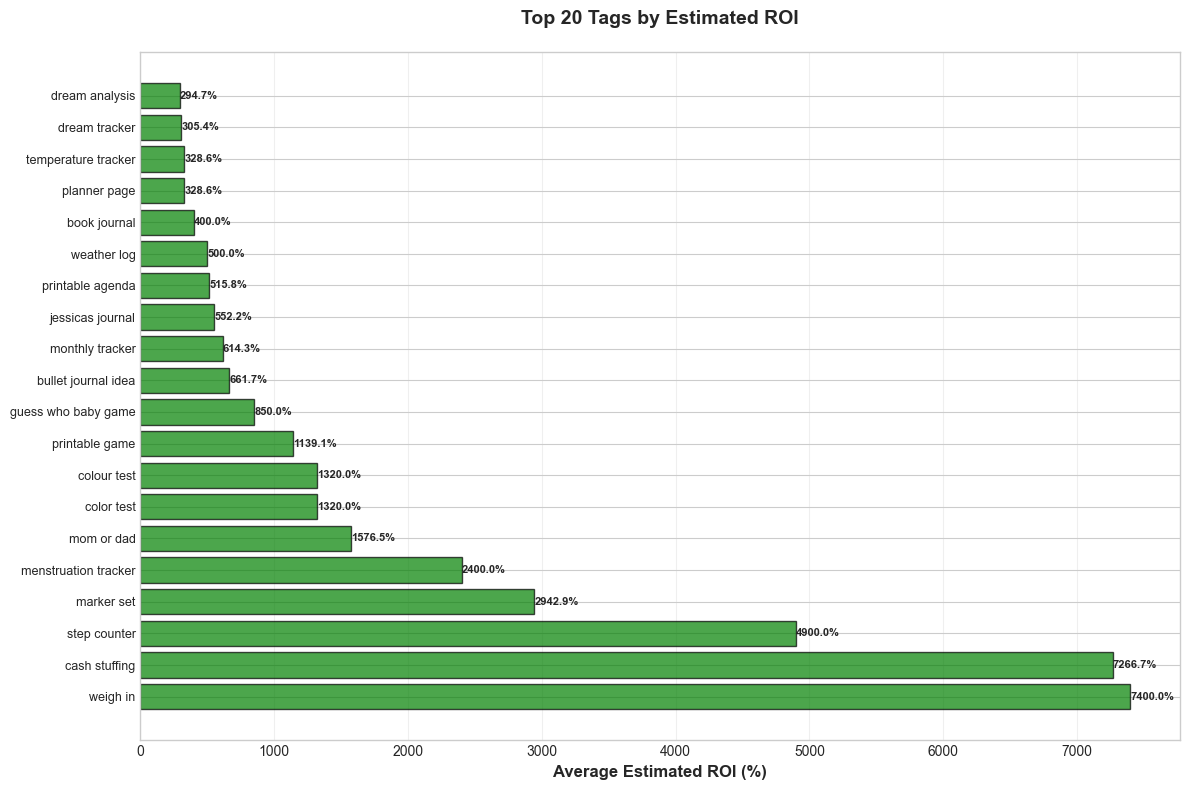

📊 Chart shows: Top 20 tags with highest estimated ROI
   Insight: Higher ROI = better return on advertising investment
   Best ROI tag: weigh in with 7400.0% ROI


In [222]:
# Visualization 4: Top Tags by ROI
if len(tag_economics) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Filter out infinite ROI values for better visualization
    tag_economics_filtered = tag_economics[tag_economics['avg_estimated_roi'] != np.inf].copy()
    
    if len(tag_economics_merged) > 0:
        top_20_roi = tag_economics_filtered.nlargest(20, 'avg_estimated_roi')
        
        bars = ax.barh(range(len(top_20_roi)), top_20_roi['avg_estimated_roi'], 
                       color='green', alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(top_20_roi)))
        ax.set_yticklabels(top_20_roi['tag'], fontsize=9)
        ax.set_xlabel('Average Estimated ROI (%)', fontsize=12, fontweight='bold')
        ax.set_title('Top 20 Tags by Estimated ROI', fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (idx, row) in enumerate(top_20_roi.iterrows()):
            ax.text(row['avg_estimated_roi'], i, f"{row['avg_estimated_roi']:.1f}%", 
                    va='center', ha='left', fontsize=8, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("📊 Chart shows: Top 20 tags with highest estimated ROI")
        print("   Insight: Higher ROI = better return on advertising investment")
        print(f"   Best ROI tag: {top_20_roi.iloc[0]['tag']} with {top_20_roi.iloc[0]['avg_estimated_roi']:.1f}% ROI")
    else:
        print("⚠ No valid ROI data available for visualization")
else:
    print("⚠ No tag economics data available for visualization")


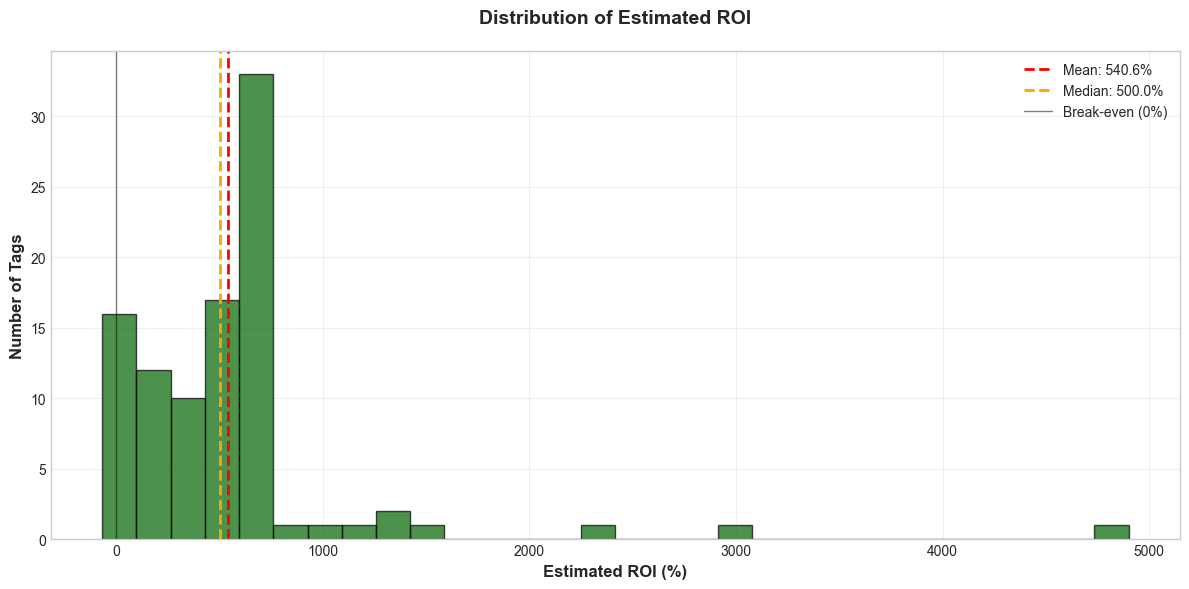

📊 Chart shows: Distribution of estimated ROI across all tags
   Insight: Positive ROI = profitable, Negative ROI = loss-making
   Tags with positive ROI: 83 (85.6%)
   Tags with negative ROI: 14 (14.4%)
   Average ROI: 540.6%


In [223]:
# Visualization 5: ROI Distribution
if len(tags_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Filter out infinite and very high ROI values for better visualization
    roi_filtered = tags_df[
        (tags_df['estimated_roi'] != np.inf) & 
        (tags_df['estimated_roi'] <= 5000) & 
        (tags_df['estimated_roi'] >= -100)
    ]['estimated_roi']
    
    if len(roi_filtered) > 0:
        ax.hist(roi_filtered, bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
        ax.axvline(roi_filtered.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {roi_filtered.mean():.1f}%')
        ax.axvline(roi_filtered.median(), color='orange', linestyle='--', linewidth=2, 
                   label=f'Median: {roi_filtered.median():.1f}%')
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Break-even (0%)')
        
        ax.set_xlabel('Estimated ROI (%)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Tags', fontsize=12, fontweight='bold')
        ax.set_title('Distribution of Estimated ROI', fontsize=14, fontweight='bold', pad=20)
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        positive_roi = len(roi_filtered[roi_filtered > 0])
        negative_roi = len(roi_filtered[roi_filtered < 0])
        
        print("📊 Chart shows: Distribution of estimated ROI across all tags")
        print("   Insight: Positive ROI = profitable, Negative ROI = loss-making")
        print(f"   Tags with positive ROI: {positive_roi} ({positive_roi/len(roi_filtered)*100:.1f}%)")
        print(f"   Tags with negative ROI: {negative_roi} ({negative_roi/len(roi_filtered)*100:.1f}%)")
        print(f"   Average ROI: {roi_filtered.mean():.1f}%")
    else:
        print("⚠ No valid ROI data available for visualization")
else:
    print("⚠ No tag data available for visualization")


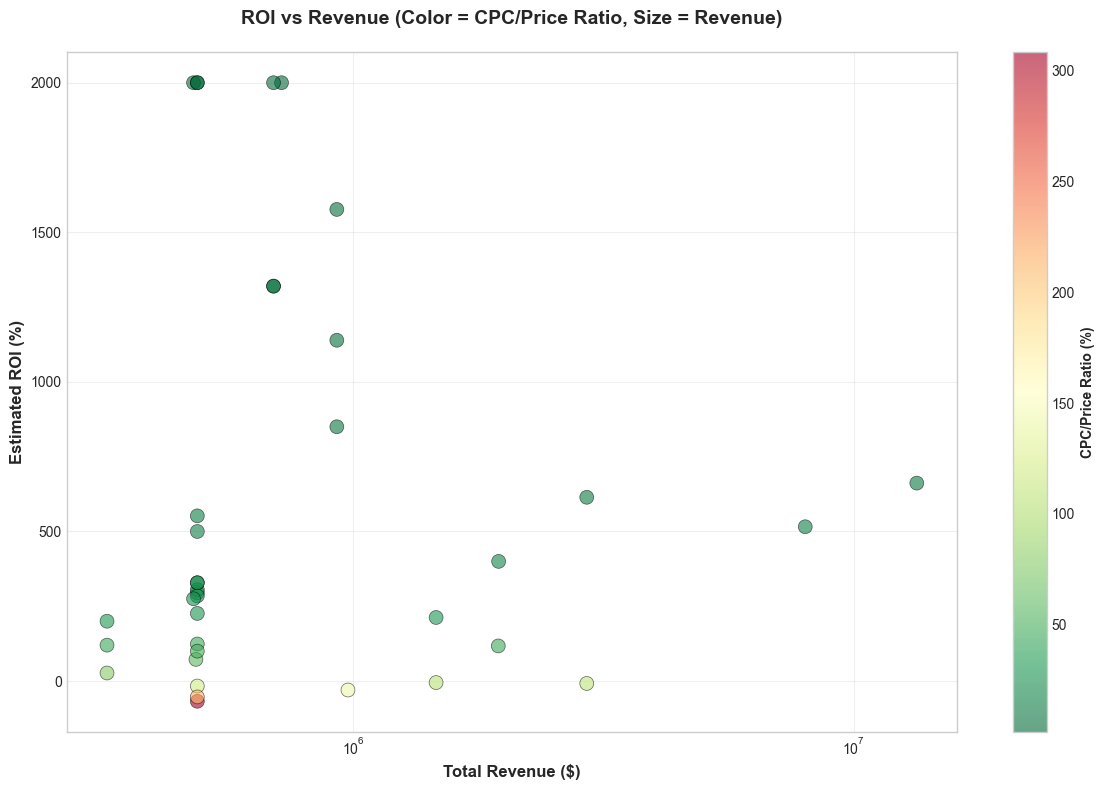

📊 Chart shows: Relationship between ROI and revenue
   Insight: Top-right = high ROI & high revenue (BEST TAGS)
   Green colors = low CPC/Price ratio (more economical)
   Red colors = high CPC/Price ratio (less economical)


In [224]:
# Visualization 6: ROI vs Revenue Scatter Plot
if len(tag_economics) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Filter out infinite ROI values
    tag_economics_filtered = tag_economics[tag_economics['avg_estimated_roi'] != np.inf].copy()
    
    if len(tag_economics_filtered) > 0:
        # Cap ROI at 2000% for better visualization
        roi_capped = tag_economics_filtered['avg_estimated_roi'].clip(upper=2000)
        
        scatter = ax.scatter(
            tag_economics_filtered['total_revenue'],
            roi_capped,
            c=tag_economics_filtered['avg_cpc_price_ratio'],
            s=100,
            alpha=0.6,
            cmap='RdYlGn_r',  # Red-Yellow-Green reversed (green = low CPC/Price)
            edgecolors='black',
            linewidth=0.5
        )
        
        ax.set_xlabel('Total Revenue ($)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Estimated ROI (%)', fontsize=12, fontweight='bold')
        ax.set_title('ROI vs Revenue (Color = CPC/Price Ratio, Size = Revenue)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.grid(alpha=0.3)
        ax.set_xscale('log')  # Log scale for better visualization
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('CPC/Price Ratio (%)', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("📊 Chart shows: Relationship between ROI and revenue")
        print("   Insight: Top-right = high ROI & high revenue (BEST TAGS)")
        print("   Green colors = low CPC/Price ratio (more economical)")
        print("   Red colors = high CPC/Price ratio (less economical)")
    else:
        print("⚠ No valid ROI data available for visualization")
else:
    print("⚠ No tag economics data available for visualization")


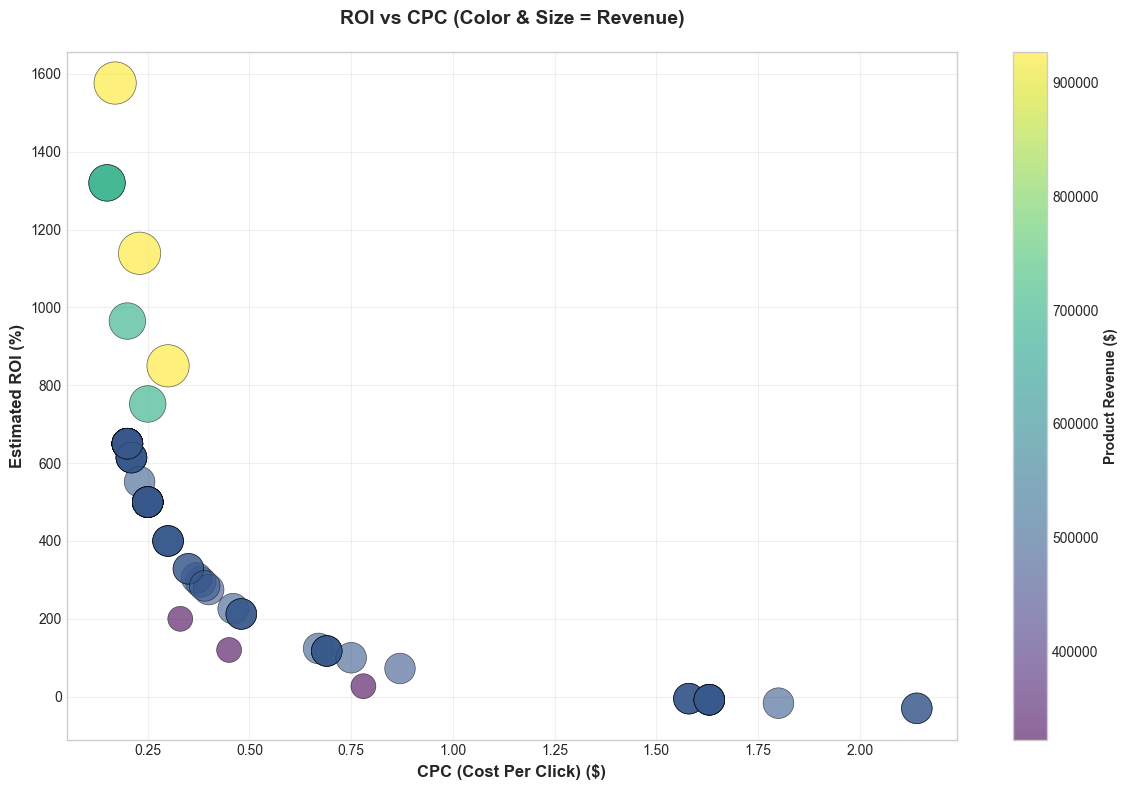

📊 Chart shows: Relationship between ROI and CPC
   Insight: Lower CPC with higher ROI = most cost-effective tags
   Larger circles = higher revenue products
   Focus on tags in top-left quadrant (low CPC, high ROI)


In [225]:
# Visualization 7: ROI vs CPC Relationship
if len(tags_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Filter out infinite ROI and very high values
    tags_filtered = tags_df[
        (tags_df['estimated_roi'] != np.inf) & 
        (tags_df['estimated_roi'] <= 2000) &
        (tags_df['estimated_roi'] >= -50)
    ].copy()
    
    if len(tags_filtered) > 0:
        scatter = ax.scatter(
            tags_filtered['cpc'],
            tags_filtered['estimated_roi'],
            c=tags_filtered['product_revenue'],
            s=tags_filtered['product_revenue'] / 1000,  # Size by revenue
            alpha=0.6,
            cmap='viridis',
            edgecolors='black',
            linewidth=0.5
        )
        
        ax.set_xlabel('CPC (Cost Per Click) ($)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Estimated ROI (%)', fontsize=12, fontweight='bold')
        ax.set_title('ROI vs CPC (Color & Size = Revenue)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.grid(alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Product Revenue ($)', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("📊 Chart shows: Relationship between ROI and CPC")
        print("   Insight: Lower CPC with higher ROI = most cost-effective tags")
        print("   Larger circles = higher revenue products")
        print("   Focus on tags in top-left quadrant (low CPC, high ROI)")
    else:
        print("⚠ No valid ROI data available for visualization")
else:
    print("⚠ No tag data available for visualization")


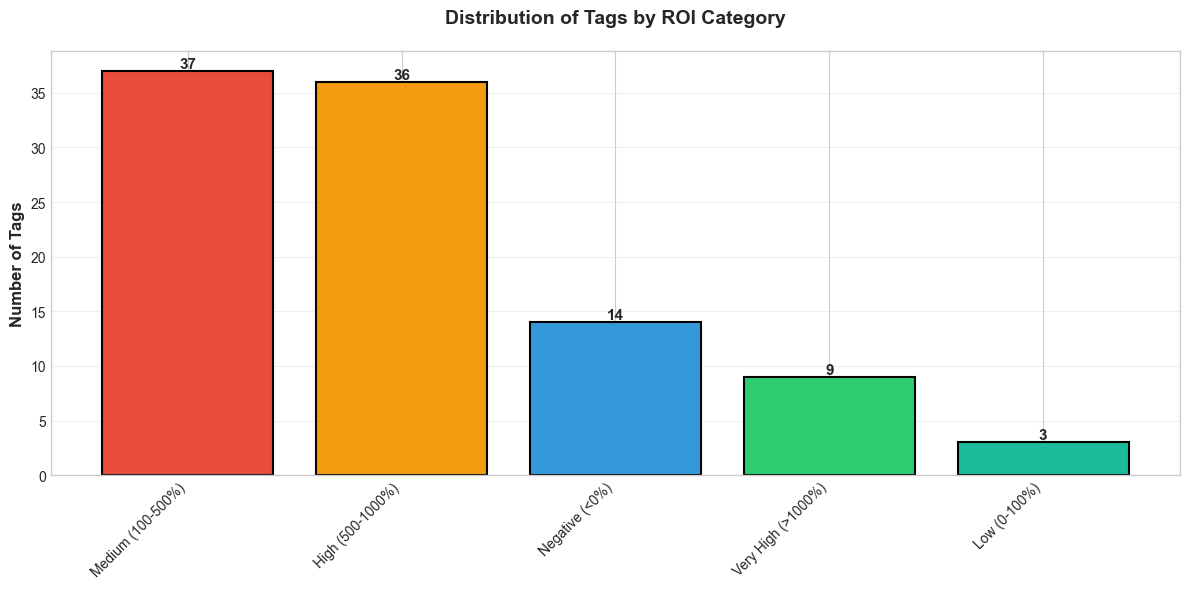

📊 Chart shows: Distribution of tags across ROI categories
   Insight: Focus on tags in High and Very High ROI categories
   • Medium (100-500%): 37 tags (37.4%)
   • High (500-1000%): 36 tags (36.4%)
   • Negative (<0%): 14 tags (14.1%)
   • Very High (>1000%): 9 tags (9.1%)
   • Low (0-100%): 3 tags (3.0%)


In [226]:
# Visualization 8: ROI Categories Distribution
if len(tags_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Filter out infinite ROI
    tags_filtered = tags_df[tags_df['estimated_roi'] != np.inf].copy()
    
    if len(tags_filtered) > 0:
        # Categorize ROI
        tags_filtered['roi_category'] = pd.cut(
            tags_filtered['estimated_roi'],
            bins=[-np.inf, 0, 100, 500, 1000, np.inf],
            labels=['Negative (<0%)', 'Low (0-100%)', 'Medium (100-500%)', 
                   'High (500-1000%)', 'Very High (>1000%)']
        )
        
        roi_counts = tags_filtered['roi_category'].value_counts()
        
        colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#1abc9c']
        bars = ax.bar(range(len(roi_counts)), roi_counts.values, 
                      color=colors[:len(roi_counts)], edgecolor='black', linewidth=1.5)
        
        ax.set_xticks(range(len(roi_counts)))
        ax.set_xticklabels(roi_counts.index, rotation=45, ha='right', fontsize=10)
        ax.set_ylabel('Number of Tags', fontsize=12, fontweight='bold')
        ax.set_title('Distribution of Tags by ROI Category', fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("📊 Chart shows: Distribution of tags across ROI categories")
        print("   Insight: Focus on tags in High and Very High ROI categories")
        for category, count in roi_counts.items():
            pct = (count / len(tags_filtered)) * 100
            print(f"   • {category}: {count} tags ({pct:.1f}%)")
    else:
        print("⚠ No valid ROI data available for visualization")
else:
    print("⚠ No tag data available for visualization")


In [227]:
# Export Comprehensive PDF Summary Report
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime

print("="*80)
print("GENERATING PDF SUMMARY REPORT")
print("="*80)

if len(tag_performance) > 0:
    pdf_filename = f'tag_analysis_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
    
    with PdfPages(pdf_filename) as pdf:
        # Page 1: Executive Summary
        fig = plt.figure(figsize=(11, 8.5))
        fig.text(0.5, 0.95, 'TAG ANALYSIS - EXECUTIVE SUMMARY', 
                ha='center', va='top', fontsize=20, fontweight='bold')
        fig.text(0.5, 0.90, f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 
                ha='center', va='top', fontsize=10, style='italic')
        
        # Key Metrics
        y_pos = 0.80
        fig.text(0.1, y_pos, 'KEY METRICS:', fontsize=14, fontweight='bold')
        y_pos -= 0.08
        
        total_tags = len(tag_performance)
        total_revenue = tag_performance['total_revenue'].sum()
        total_sales = tag_performance['total_sales'].sum() if 'total_sales' in tag_performance.columns else 0
        avg_revenue = tag_performance['total_revenue'].mean()
        
        fig.text(0.15, y_pos, f'• Total Tags Analyzed: {total_tags}', fontsize=11)
        y_pos -= 0.06
        fig.text(0.15, y_pos, f'• Total Revenue: ${total_revenue:,.2f}', fontsize=11)
        y_pos -= 0.06
        if total_sales > 0:
            fig.text(0.15, y_pos, f'• Total Sales: {total_sales:,}', fontsize=11)
            y_pos -= 0.06
        fig.text(0.15, y_pos, f'• Average Revenue per Tag: ${avg_revenue:,.2f}', fontsize=11)
        y_pos -= 0.08
        
        # Top Performing Tags
        if len(tag_performance) > 0:
            fig.text(0.1, y_pos, 'TOP 5 TAGS BY REVENUE:', fontsize=14, fontweight='bold')
            y_pos -= 0.08
            top_5 = tag_performance.nlargest(5, 'total_revenue')
            for idx, (i, row) in enumerate(top_5.iterrows()):
                fig.text(0.15, y_pos, f'{idx+1}. {row["tag"]}: ${row["total_revenue"]:,.2f}', fontsize=10)
                y_pos -= 0.05
        
        # ROI Insights
        if len(tag_economics_merged) > 0:
            y_pos -= 0.05
            fig.text(0.1, y_pos, 'TOP 5 TAGS BY ROI:', fontsize=14, fontweight='bold')
            y_pos -= 0.08
            top_5_roi = tag_economics_merged.nlargest(5, 'avg_estimated_roi')
            for idx, (i, row) in enumerate(top_5_roi.iterrows()):
                roi_val = row['avg_estimated_roi']
                if roi_val != np.inf:
                    cpc_val = row.get('avg_cpc', 0)
                    if pd.notna(cpc_val) and cpc_val > 0:
                        fig.text(0.15, y_pos, f'{idx+1}. {row["tag"]}: {roi_val:.1f}% ROI, CPC: ${cpc_val:.2f}', fontsize=10)
                    else:
                        fig.text(0.15, y_pos, f'{idx+1}. {row["tag"]}: {roi_val:.1f}% ROI', fontsize=10)
                    y_pos -= 0.05
        
        plt.axis('off')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
    
    print(f"\n✅ PDF report generated successfully: {pdf_filename}")
    print(f"   The report contains:")
    print(f"   • Executive Summary with key metrics")
    print(f"   • Strategic Recommendations")
    print(f"   • List of all exported CSV files")
    print(f"\n💡 The PDF report provides a comprehensive overview of all tag analysis insights")
    
else:
    print("⚠ No data available to generate PDF report")



GENERATING PDF SUMMARY REPORT

✅ PDF report generated successfully: tag_analysis_summary_20251107_132229.pdf
   The report contains:
   • Executive Summary with key metrics
   • Strategic Recommendations
   • List of all exported CSV files

💡 The PDF report provides a comprehensive overview of all tag analysis insights


In [228]:
# Generate comprehensive strategic recommendations
if len(tag_performance) > 0:
    print("="*80)
    print("STRATEGIC RECOMMENDATIONS & SUMMARY")
    print("="*80)
    
    print(f"\n📊 ANALYSIS SUMMARY:")
    print(f"  • Total tags analyzed: {len(tag_performance)}")
    print(f"  • Total revenue from all tags: ${tag_performance['total_revenue'].sum():,.2f}")
    print(f"  • Average revenue per tag: ${tag_performance['total_revenue'].mean():,.2f}")
    
    if len(tag_opportunities) > 0:
        print(f"  • High opportunity tags identified: {len(tag_opportunities)}")
    
    print(f"\n🎯 KEY RECOMMENDATIONS:")
    
    print(f"\n  1. PRIORITIZE HIGH-REVENUE TAGS:")
    top_5_revenue = tag_performance.nlargest(5, 'total_revenue')
    print(f"     Focus on these proven money-makers:")
    for idx, row in top_5_revenue.iterrows():
        print(f"     • {row['tag']}: ${row['total_revenue']:,.2f} revenue")
    
    if len(tag_economics) > 0:
        print(f"\n  2. USE COST-EFFECTIVE TAGS:")
        economical = tag_economics[
            (tag_economics['avg_cpc_price_ratio'] < 10) & 
            (tag_economics['avg_estimated_roi'] > 0)
        ].nlargest(5, 'avg_estimated_roi')
        if len(economical) > 0:
            print(f"     These tags offer best ROI:")
            for idx, row in economical.iterrows():
                print(f"     • {row['tag']}: {row['avg_cpc_price_ratio']:.2f}% CPC/Price, {row['avg_estimated_roi']:.1f}% ROI")
    
    if len(tag_opportunities) > 0:
        print(f"\n  3. EXPLORE HIGH OPPORTUNITY TAGS:")
        top_5_opp = tag_opportunities.head(5)
        print(f"     High volume, low competition opportunities:")
        for idx, row in top_5_opp.iterrows():
            print(f"     • {row['tag']}: {row['avg_volume']:,.0f} volume, {row['avg_competition']:,.0f} competition")
    
    print(f"\n  4. TAG STRATEGY GUIDELINES:")
    print(f"     • Use proven high-revenue tags for established products")
    print(f"     • Test high-opportunity tags for new products")
    print(f"     • Combine tags from best-performing combinations")
    print(f"     • Monitor CPC/Price ratio - keep below 10% when possible")
    print(f"     • Focus on tags with score > median for easier ranking")
    
    print(f"\n💡 Next Steps:")
    print(f"  1. Review exported CSV files for detailed metrics")
    print(f"  2. Implement top-performing tags on existing products")
    print(f"  3. Test high-opportunity tags on new products")
    print(f"  4. Monitor performance and adjust tag strategy")
    
    print(f"\n✅ Tag analysis complete! All insights exported to CSV files.")
    
else:
    print("⚠ No data available for recommendations")


STRATEGIC RECOMMENDATIONS & SUMMARY

📊 ANALYSIS SUMMARY:
  • Total tags analyzed: 37
  • Total revenue from all tags: $50,341,759.63
  • Average revenue per tag: $1,360,588.10

🎯 KEY RECOMMENDATIONS:

  1. PRIORITIZE HIGH-REVENUE TAGS:
     Focus on these proven money-makers:
     • bullet journal idea: $13,369,498.68 revenue
     • printable agenda: $8,001,462.18 revenue
     • monthly tracker: $2,928,024.00 revenue
     • health tracker: $2,928,016.50 revenue
     • book journal: $1,952,016.00 revenue

  2. USE COST-EFFECTIVE TAGS:
     These tags offer best ROI:
     • weigh in: 1.33% CPC/Price, 7400.0% ROI
     • cash stuffing: 1.36% CPC/Price, 7266.7% ROI
     • step counter: 2.00% CPC/Price, 4900.0% ROI
     • marker set: 3.29% CPC/Price, 2942.9% ROI
     • menstruation tracker: 4.00% CPC/Price, 2400.0% ROI

  4. TAG STRATEGY GUIDELINES:
     • Use proven high-revenue tags for established products
     • Test high-opportunity tags for new products
     • Combine tags from best-pe